## Working Example

Now that we have all key ingredients in place, we can proceed to test our CUDA implementation and its Python interface. Before we do this, let us briefly recapitulate the key steps in performing any particle-based simulation.

### Review on particle-based simulation

Our simulation workflow consists of three steps:

1. Creating the initial configuration; 
2. Executing the simulation; 
3. Analyzing the results.

Let us start with a working example of a full simulation. 

We read the initial configuration stored in the file *init.json* with $N=36,000$ randomly placed particles in a square box of size $L=300$. We assume that all particles have the same radius $a=1$. Further, each particle is self-propelled with the active force of magnitude $\alpha=1$ and experiences translational friction with friction coefficient $\gamma_t = 1$. Rotational friction is set to $\gamma_r = 1$ and the rotational diffusion constant to $D_r = 0.1$. Particles within the distance $d=2$ of each other experience the polar alignment torque of magnitude $J=1$.

We use the time step $\delta t = 0.01$ and run the simulation for $1,000$ time steps. We record a snapshot of the simulation once every 10 time steps.




In [4]:
%matplotlib widget
import gpumd as md
import time
import numpy as np

json_reader = md.fast_read_json("test_particle.json") #here we read the json file in C++
system = md.System(json_reader.particles, json_reader.box)

#get the GPU hardware properties
cuda_info = system.get_execution_policies()
print("** Device parameters **")
print(cuda_info.getDeviceProperty())
print("** Lunch parameters **")
print("GridSize=", cuda_info.getGridSize(), "BlockSize=", cuda_info.getBlockSize())

** Device parameters **

Device 0 NVIDIA GeForce RTX 3060 Ti
CUDA Driver Version / Runtime Version 11.6/10.1
CUDA Capability Major/Minor version number: 8.6
Total amount of global memory 7 GB
38 Multiprocessors 64 CUDA Cores/MP 2432 CUDA Cores 
GPU Clock rate 1.665000 GHz 


** Lunch parameters **
GridSize= 160 BlockSize= 256
Reading file test_particle.json success


t=0


TypeError: add_force(): incompatible function arguments. The following argument types are supported:
    1. (self: gpumd.md.nvccmodule.Evolver, arg0: str, arg1: Dict[str, float]) -> None

Invoked with: <gpumd.md.nvccmodule.Evolver object at 0x7f484848a8f0>, 'Self Propulsion', {'alpha': array([1, 2, 3])}

 ********************************************
 Linkded list
Numpoints=3
Ncells=38 38
LengthCells=1.31579 1.31579
cellHead.size()=1444
cellNext.size()=3
 ********************************************
 ********************************************
 Neighbourlist list
neighbourlist.size()=300
neighbourlist rcut =1.3
neighbourlist skin =0.3
 ********************************************
 ********************************************
 Linkded list
Numpoints=3
Ncells=38 38
LengthCells=1.31579 1.31579
cellHead.size()=1444
cellNext.size()=3
 ********************************************
 ********************************************
 Neighbourlist list
neighbourlist.size()=300
neighbourlist rcut =1.3
neighbourlist skin =0.3
 ********************************************


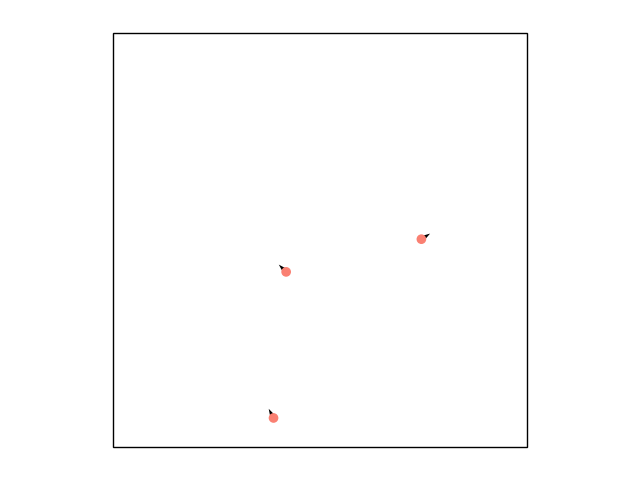

In [10]:
dump = md.Dump(system)          # Create a dump object
print("t=0")
dump.show(notebook=True)        # Plot the particles with matplotlib

evolver = md.Evolver(system)    # Create a system evolver object

#add the forces and torques

# Create pairwise repulsive interactions with the spring contant k = 10 and range a = 1.0
evolver.add_force("Harmonic Force", {"k": 10.0, "a": 1.0})
alpha = np.array([1, 2, 3])
# Create self-propulsion, self-propulsion strength alpha = 10.0
evolver.add_force("Self Propulsion", {"alpha": alpha})

# Create pairwise polar alignment with alignment strength J = 10.0 and range a = 1.0
evolver.add_torque("Polar Align", {"k": 10.0, "a": 1.0})

#add integrators
# Integrator for updating particle position, friction gamma = 1.0 , "random seed" seed = 10203 and no thermal noise
evolver.add_integrator("Brownian Positions", {"T": 0.0, "gamma": 1.0, "seed": 10203})

# Integrator for updating particle orientation, friction gamma = 1.0, "rotation" T = 0.1, D_r = 0.0, "random seed" seed = 10203
evolver.add_integrator("Brownian Rotation", {"T": 0.1, "gamma": 1.0, "seed": 10203})

evolver.set_time_step(1e-2) # Set the time step for all the integrators

<div align="center">
<img src="./L=300.0000.png" style="width: 1x;"/>
</div>

36000 particles - 10000 steps execution time 3.55[s]
t=10000


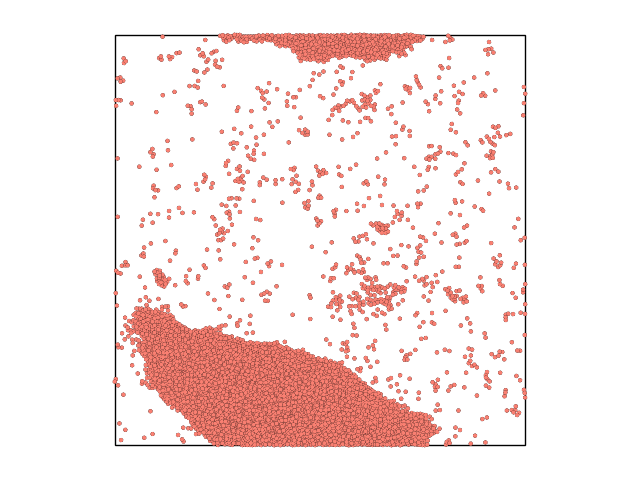

In [21]:
start_clock = time.time()
for t in range(10000):
    #print("Time step : ", t)
    evolver.evolve()    # Evolve the system by one time step
    #if t % 10 == 0:     # Produce snapshot of the simulation once every 10 time steps
    #    dump.dump_vtp('test_{:05d}.vtp'.format(t))
print('9000 particles - 10000 steps execution time {:.2f}[s]'.format(time.time() - start_clock))
print("t=10000")
dump.show(notebook=True)              # Plot the particles with matplotlib    

<div align="center">
<img src="./L=300.0001.png" style="width: 1x;"/>
</div>

<div align="center">
<img src="./L=300_close.0001.png" style="width="0";"/>
</div>

# Speed up comparison

Now let's see how the ``GPU`` code compare with the previous session.

<div align="center">
<img src="./benchmark2.png" style="width: 0.5x;"/>
</div>

As you can see, even the first round on the **Assess, Parallelize, Optimize, Deploy** give us 2435x times faster than the ``Python`` code, and 9.3x times than the ``c++`` code.

## References
* [https://devblogs.nvidia.com/](https://devblogs.nvidia.com/)
* [https://docs.nvidia.com/cuda/cuda-c-programming-guide](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html)
* [https://docs.nvidia.com/cuda/cuda-c-best-practices-guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html)
* Cheng, John, Max Grossman, and Ty McKercher. Professional CUDA c programming. John Wiley & Sons, 2014.
* Jaegeun Han and Bharatkumar Sharma Learn CUDA Programming. Packt Publishing, 2019.
